<a href="https://colab.research.google.com/github/2hg7274/CodeStates/blob/main/Section2%20Project/Loan_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan Prediction Based on Customer Behavior

# 라이브러리 호출

In [7]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, roc_auc_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from category_encoders import OneHotEncoder, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator
from imblearn.over_sampling import SMOTE

import eli5
from eli5.sklearn import PermutationImportance

# 데이터 불러오기

In [11]:
train = pd.read_csv('https://raw.githubusercontent.com/2hg7274/CodeStates/main/Section2%20Project/Data/Training%20Data.csv')

In [12]:
train.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [13]:
# train데이터와 test데이터의 ID 컬럼 동일시 하기 위해 컬럼명 변경
train.rename(columns={'Id':'ID'}, inplace=True)

# Data Proprocessing

## 중복 ID 검사

In [14]:
def analysis_on_features(df):
    '''
    데이터 프레임에 중복된 Id가 있는지 파악
    '''
    duplicated_rows = 0
    dupli = df.duplicated(subset=['ID'])
    for i in dupli.index:
        if dupli[i] == True:
            duplicated_rows += 1
            print(i)
    
    return duplicated_rows

In [15]:
train_duplicated_rows = analysis_on_features(train)

print('train 데이터의 중복열 개수는 {}개 이다.' .format(train_duplicated_rows))

train 데이터의 중복열 개수는 0개 이다.


## Feature Engineering 및 Preprocessing

## PCA
상관관계가 높았던'Experience'와 'CURRENT_JOB_YRS'에 대해 주성분 분석

In [16]:
pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(train[['Experience', 'CURRENT_JOB_YRS']])

In [17]:
pca.explained_variance_ratio_
# 1차원으로 축소를 하여도 설명력이 86.7%이다. 
# 따라서 1차원으로 차원 축소 진행

array([0.86780334, 0.13219666])

In [18]:
# 전처리 함수
def eda_preprocess(df):
    # 분석에 사용하지 않을 'ID' 컬럼 삭제
    df = df.drop(['ID'], axis=1)

    # 'CITY'컬럼 삭제 -> 너무 높은 카디널리티
    df = df.drop(['CITY'], axis=1)

    # 'OutofWork_time' -> 직장이 없던 기간
    df['OutofWork_time'] = df['Experience'] - df['CURRENT_JOB_YRS']

    # PCA로 새로운 컬럼 생성 후, 'Experience', 'CURRENT_JOB_YRS'컬럼 삭제 -> PCA로 차원 축소를 진행
    standard_scle = StandardScaler()
    df[['Experience', 'CURRENT_JOB_YRS']] = standard_scle.fit_transform(df[['Experience', 'CURRENT_JOB_YRS']])
    pca = PCA(n_components=1)
    printcipalComponents = pca.fit_transform(df[['Experience', 'CURRENT_JOB_YRS']])
    PCAdf = pd.DataFrame(data=printcipalComponents, columns = ['PC1'])
    df = pd.concat([df, PCAdf], axis=1)    

    df = df.drop(['Experience'], axis=1)
    df = df.drop(['CURRENT_JOB_YRS'], axis=1)

    return df



In [19]:
train_processed = eda_preprocess(train.copy())

In [20]:
train_processed

,Income,Age,Married/Single,House_Ownership,Car_Ownership,Profession,STATE,CURRENT_HOUSE_YRS,Risk_Flag,OutofWork_time,PC1
0,1303834,23,single,rented,no,Mechanical_engineer,Madhya_Pradesh,13,0,0,-1.480938
1,7574516,40,single,rented,no,Software_Developer,Maharashtra,13,0,1,0.506974
2,3991815,66,married,rented,no,Technical_writer,Kerala,10,0,0,-1.169253
3,6256451,41,single,rented,yes,Software_Developer,Odisha,12,1,0,-1.792624
4,5768871,47,single,rented,no,Civil_servant,Tamil_Nadu,14,1,8,-0.538534
...,...,...,...,...,...,...,...,...,...,...,...
251995,8154883,43,single,rented,no,Surgeon,West_Bengal,11,0,7,0.278721
251996,2843572,26,single,rented,no,Army_officer,Madhya_Pradesh,11,0,4,-0.074680
251997,4522448,46,single,rented,no,Design_Engineer,Maharashtra,12,0,0,-0.234197
251998,6507128,45,single,rented,no,Graphic_Designer,Puducherry,10,0,0,-2.415994


# Modeling - Risk_Flag 예측

## 변수 및 모델 정의

In [21]:
# train, vl 데이터 나누는 함수
def split(df, target):
    X = df.drop([target], axis=1)
    y = df[target]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

In [22]:
train1 = train_processed.copy()

In [23]:
# train / test 데이터 나누기
X_train, X_test, y_train, y_test = split(train1, 'Risk_Flag')

In [24]:
# train / val 데이터 나누기
train1 = pd.concat([X_train, y_train], axis=1)
X_train, X_val, y_train, y_val = split(train1, 'Risk_Flag')

In [25]:
print('X_train의 형태: ', X_train.shape)
print('X_val의 형태: ', X_val.shape)
print('X_test의 형태: ', X_test.shape)

X_train의 형태:  (161280, 10)
X_val의 형태:  (40320, 10)
X_test의 형태:  (50400, 10)


#### 기준 모델

In [26]:
# 기준 모델
# 평가지표는 accuracy, f1 score
acc_f1_score = {}

baseline_predict = [train1['Risk_Flag'].mode()[0]]*len(X_val)

baseline_acc = accuracy_score(y_val, baseline_predict)
baseline_f1 = f1_score(y_val, baseline_predict)

acc_f1_score['baseline'] = [baseline_acc, baseline_f1]


#### LogisticRegression

In [27]:
# LogisticRegression
pipe_LogisticR = Pipeline([
    ('onehot', OneHotEncoder(cols=['House_Ownership','Car_Ownership', 'Married/Single'], use_cat_names=True)),
    ('ordinal', OrdinalEncoder()),
    ('logistic', LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42))
])

dists_LR = {
    'logistic__C': [1.0, 2.0, 3.0],
    'logistic__solver': ['lbfgs', 'liblinear', 'saga']
}

clf_LR = RandomizedSearchCV(
    pipe_LogisticR,
    param_distributions=dists_LR,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42
)

clf_LR.fit(X_train, y_train)
print('최적 하퍼라미터: ', clf_LR.best_params_, '\n')
print('Accuracy ', clf_LR.best_score_)


최적 하퍼라미터:  {'logistic__solver': 'lbfgs', 'logistic__C': 1.0} 

Accuracy  0.8771949404761905


In [28]:
pipe_LogisticR = clf_LR.best_estimator_
LR_pred = pipe_LogisticR.predict(X_val)

LR_acc = accuracy_score(y_val, LR_pred)
LR_f1 = f1_score(y_val, LR_pred)

acc_f1_score['LogisticRegression'] = [LR_acc, LR_f1]

#### RandomForestClassifier

In [29]:
# RandomForestClassifier
pipe_RFC = Pipeline([
    ('onehot', OneHotEncoder(cols=['House_Ownership','Car_Ownership', 'Married/Single'], use_cat_names=True)),
    ('ordinal', OrdinalEncoder()),
    ('RFclassifier', RandomForestClassifier(class_weight='balanced', n_jobs=-1, oob_score=True, random_state=42))
])

dists_RFC = {
    'RFclassifier__criterion': ['gini', 'entropy', 'log_loss'],
    'RFclassifier__max_depth': [10, 15, 20],
    'RFclassifier__min_samples_split': [2, 3, 4],
    'RFclassifier__min_samples_leaf': [1, 2, 3],
    'RFclassifier__max_features': ['sqrt', 'log2']
}

clf_RFC = RandomizedSearchCV(
    pipe_RFC,
    param_distributions=dists_RFC,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42
)

clf_RFC.fit(X_train, y_train)
print('최적 하퍼라미터: ', clf_RFC.best_params_, '\n')
print('Accuracy ', clf_RFC.best_score_)


최적 하퍼라미터:  {'RFclassifier__min_samples_split': 3, 'RFclassifier__min_samples_leaf': 1, 'RFclassifier__max_features': 'log2', 'RFclassifier__max_depth': 20, 'RFclassifier__criterion': 'entropy'} 

Accuracy  0.8960131448412698


In [30]:
pipe_RFC = clf_RFC.best_estimator_
RFC_pred = pipe_RFC.predict(X_val)

RFC_acc = accuracy_score(y_val, RFC_pred)
RFC_f1 = f1_score(y_val, RFC_pred)

acc_f1_score['RandomForestClassifier'] = [RFC_acc, RFC_f1]

#### XGBoostClassifier

In [31]:
class XGBoostWithEarlyStopClassifier(BaseEstimator):
    def __init__(self, early_stopping_rounds=7, test_size=0.2, 
                 eval_metric='error', scale_pos_weight=7, n_jobs=-1, random_state=42, **estimator_params):
        self.early_stopping_rounds = early_stopping_rounds
        self.test_size = test_size
        self.eval_metric=eval_metric='error' 
        self.scale_pos_weight = scale_pos_weight
        self.n_jobs = n_jobs       
        self.random_state = random_state
        if self.estimator is not None:
            self.set_params(**estimator_params)

    def set_params(self, **params):
        return self.estimator.set_params(**params)

    def get_params(self, **params):
        return self.estimator.get_params()

    def fit(self, X, y):
        x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=42)
        self.estimator.fit(x_train, y_train, 
                           early_stopping_rounds=self.early_stopping_rounds, 
                           eval_metric=self.eval_metric, eval_set=[(x_val, y_val)])
        return self

    def predict(self, X):
        return self.estimator.predict(X)

class XGBoostClassifierWithEarlyStop(XGBoostWithEarlyStopClassifier):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBClassifier()
        super(XGBoostClassifierWithEarlyStop, self).__init__(*args, **kwargs)

In [32]:
# XGBClassifier
pipe_XGBC = Pipeline([
    ('onehot', OneHotEncoder(cols=['House_Ownership','Car_Ownership', 'Married/Single'], use_cat_names=True)),
    ('ordinal', OrdinalEncoder()),
    ('XGBC', XGBoostClassifierWithEarlyStop())
])

dists_XGBc = {
    'XGBC__max_depth': [10, 15, 20],
    'XGBC__max_leaves': [1, 2, 3,],
    'XGBC__learning_rate': [0.1, 0.2]
}

clf_XGBc= RandomizedSearchCV(
    pipe_XGBC,
    param_distributions=dists_XGBc,
    n_iter=5,
    cv=5,
    scoring='accuracy',
    random_state=42
)

clf_XGBc.fit(X_train, y_train)
print('최적 하퍼라미터: ', clf_XGBc.best_params_, '\n')
print('Accuracy: ', clf_XGBc.best_score_)


[0]	validation_0-error:0.117574
Will train until validation_0-error hasn't improved in 7 rounds.
[1]	validation_0-error:0.116567
[2]	validation_0-error:0.117109
[3]	validation_0-error:0.116644
[4]	validation_0-error:0.116644
[5]	validation_0-error:0.11676
[6]	validation_0-error:0.116838
[7]	validation_0-error:0.117419
[8]	validation_0-error:0.116915
Stopping. Best iteration:
[1]	validation_0-error:0.116567

[0]	validation_0-error:0.116334
Will train until validation_0-error hasn't improved in 7 rounds.
[1]	validation_0-error:0.117109
[2]	validation_0-error:0.116334
[3]	validation_0-error:0.115365
[4]	validation_0-error:0.115753
[5]	validation_0-error:0.115792
[6]	validation_0-error:0.116489
[7]	validation_0-error:0.117109
[8]	validation_0-error:0.117574
[9]	validation_0-error:0.118233
[10]	validation_0-error:0.118582
Stopping. Best iteration:
[3]	validation_0-error:0.115365

[0]	validation_0-error:0.11986
Will train until validation_0-error hasn't improved in 7 rounds.
[1]	validation_0

In [33]:
pipe_XGBC = clf_XGBc.best_estimator_
pipe_XGBC.fit(X_train, y_train)
XGBC_pred = pipe_XGBC.predict(X_val)

XGBC_acc = accuracy_score(y_val, XGBC_pred),
XGBC_f1 = f1_score(y_val, XGBC_pred)

acc_f1_score['XGBClassifier'] = [XGBC_acc, XGBC_f1]

[0]	validation_0-error:0.112723
Will train until validation_0-error hasn't improved in 7 rounds.
[1]	validation_0-error:0.113281
[2]	validation_0-error:0.111669
[3]	validation_0-error:0.110057
[4]	validation_0-error:0.109561
[5]	validation_0-error:0.108631
[6]	validation_0-error:0.107608
[7]	validation_0-error:0.107329
[8]	validation_0-error:0.107422
[9]	validation_0-error:0.107236
[10]	validation_0-error:0.107143
[11]	validation_0-error:0.107174
[12]	validation_0-error:0.107081
[13]	validation_0-error:0.107019
[14]	validation_0-error:0.106833
[15]	validation_0-error:0.10736
[16]	validation_0-error:0.107174
[17]	validation_0-error:0.107701
[18]	validation_0-error:0.107236
[19]	validation_0-error:0.107763
[20]	validation_0-error:0.107639
[21]	validation_0-error:0.107825
Stopping. Best iteration:
[14]	validation_0-error:0.106833



#### AdaBoostClassifier

In [34]:
# AdaBoostClassifier
pipe_Ada = Pipeline([
    ('onehot', OneHotEncoder(cols=['House_Ownership','Car_Ownership', 'Married/Single'], use_cat_names=True)),
    ('ordinal', OrdinalEncoder()),
    ('ada', AdaBoostClassifier(random_state=42))
])

dists_ada = {
    'ada__n_estimators': [50, 100, 150],
    'ada__learning_rate': [1.0, 2.0],
    'ada__algorithm': ['SAMME', 'SAMME.R']
}

clf_ada = RandomizedSearchCV(
    pipe_Ada,
    param_distributions=dists_ada,
    n_iter=5,
    cv=5,
    scoring='accuracy',
    random_state=42
)

clf_ada.fit(X_train, y_train)
print('최적 하퍼라미터: ', clf_ada.best_params_, '\n')
print('Accuracy: ', clf_ada.best_score_)

최적 하퍼라미터:  {'ada__n_estimators': 150, 'ada__learning_rate': 1.0, 'ada__algorithm': 'SAMME.R'} 

Accuracy:  0.877325148809524


In [35]:
pipe_Ada = clf_ada.best_estimator_
pipe_Ada.fit(X_train, y_train)
Ada_pred = pipe_Ada.predict(X_val)

Ada_acc = accuracy_score(y_val, Ada_pred),
Ada_f1 = f1_score(y_val, Ada_pred)

acc_f1_score['AdaBoostClassifier'] = [Ada_acc, Ada_f1]

#### GradientBoostClassifier

In [36]:
# GradientBoostClassifier
pipe_GBC = Pipeline([
    ('onehot', OneHotEncoder(cols=['House_Ownership','Car_Ownership', 'Married/Single'], use_cat_names=True)),
    ('ordinal', OrdinalEncoder()),
    ('gbc', GradientBoostingClassifier(random_state=42))
])

dists_gbc = {
    'gbc__learning_rate': [0.1, 0.2, 0.3],
    'gbc__n_estimators': [100, 120],
    'gbc__min_samples_split': [2, 3, 4],
    'gbc__min_samples_leaf': [1, 2, 3],
    'gbc__max_depth': [3, 4, 5]
}

clf_gbc = RandomizedSearchCV(
    pipe_GBC,
    param_distributions=dists_gbc,
    n_iter=4,
    cv=5,
    scoring='accuracy',
    random_state=42
)

clf_gbc.fit(X_train, y_train)
print('최적 하퍼라미터: ', clf_gbc.best_params_, '\n')
print('Accuracy: ', clf_gbc.best_score_)

최적 하퍼라미터:  {'gbc__n_estimators': 100, 'gbc__min_samples_split': 3, 'gbc__min_samples_leaf': 3, 'gbc__max_depth': 5, 'gbc__learning_rate': 0.3} 

Accuracy:  0.883141121031746


In [37]:
pipe_GBC = clf_gbc.best_estimator_
pipe_GBC.fit(X_train, y_train)
Gbc_pred = pipe_GBC.predict(X_val)

Gbc_acc = accuracy_score(y_val, Gbc_pred),
Gbc_f1 = f1_score(y_val, Gbc_pred)

acc_f1_score['GradientBoostClassifier'] = [Gbc_acc, Gbc_f1]

In [38]:
# 모델들의 accuracy와 f1 비교 
acc_f1_score

{'AdaBoostClassifier': [(0.8777281746031746,), 0.003637833468067906],
 'GradientBoostClassifier': [(0.8849206349206349,), 0.19276270006958943],
 'LogisticRegression': [0.8775545634920635, 0.0],
 'RandomForestClassifier': [0.8953869047619047, 0.6423605222994744],
 'XGBClassifier': [(0.8965773809523809,), 0.4884690873405299],
 'baseline': [0.8775545634920635, 0.0]}

## 모델 선택
정확도 점수로 모델을 선택 한다면 XGBClassifier가 선택되어야 한다.  
하지만 f1점수를 보면 RandomForestClassifier가 더 높은 것을 알 수 있고, 정확도 또한 XGBClassifier와 차이가 심하지 않다.  
따라서 ***RnadomForestClassifier모델***을 선택한다.  

### 가장 좋은 모델의 성능 확인

In [39]:
blm_pred = pipe_RFC.predict(X_test)

blm_acc = accuracy_score(y_test, blm_pred)
blm_f1 = f1_score(y_test, blm_pred)


print(f' RandomForestClassifier의 예측 성능-> Accuracty: {blm_acc}, F-1 Score: {blm_f1}')

 RandomForestClassifier의 예측 성능-> Accuracty: 0.8946428571428572, F-1 Score: 0.6436241610738255


In [40]:
print(classification_report(y_test, blm_pred, target_names=['class 0', 'class 1']))


              precision    recall  f1-score   support

     class 0       0.97      0.91      0.94     44147
     class 1       0.55      0.77      0.64      6253

    accuracy                           0.89     50400
   macro avg       0.76      0.84      0.79     50400
weighted avg       0.91      0.89      0.90     50400



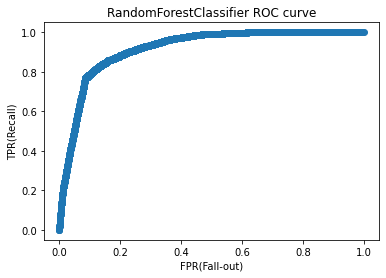

In [41]:
y_pred_proba_randomforest = pipe_RFC.predict_proba(X_val)[:,1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_randomforest)
roc = pd.DataFrame({
    'FPR(Fall-out)':fpr,
    'TPRate(Recall)':tpr,
    'Threshold':thresholds
})

plt.scatter(fpr, tpr)
plt.title('RandomForestClassifier ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')
plt.show()

In [42]:
# 최적의 threshold 찾기
optimal_idx_randomforest = np.argmax(tpr-fpr)
optimal_threshold_randomforest = thresholds[optimal_idx_randomforest]
print('idx: ', optimal_idx_randomforest, ', threshold: ', optimal_threshold_randomforest, '\n')

y_pred_optimal_randomforest = y_pred_proba_randomforest >= optimal_threshold_randomforest
print('최적의 threshold를 임계값으로 할 때')
print(classification_report(y_val, y_pred_optimal_randomforest), '\n')


y_pred_05 = y_pred_proba_randomforest >= 0.5
print('0.5 임계값으로 할 때')
print(classification_report(y_val, y_pred_05), '\n')

auc_score = roc_auc_score(y_val, y_pred_proba_randomforest)
print('RandomForestClassifier AUC Score: ',auc_score)

idx:  1919 , threshold:  0.3434905024660628 

최적의 threshold를 임계값으로 할 때
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     35383
           1       0.45      0.84      0.59      4937

    accuracy                           0.86     40320
   macro avg       0.71      0.85      0.75     40320
weighted avg       0.91      0.86      0.87     40320
 

0.5 임계값으로 할 때
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     35383
           1       0.55      0.77      0.64      4937

    accuracy                           0.90     40320
   macro avg       0.76      0.84      0.79     40320
weighted avg       0.92      0.90      0.90     40320
 

RandomForestClassifier AUC Score:  0.9175512454581973


In [43]:
test_pred_proba_RFC = pipe_RFC.predict_proba(X_test)[:,1]

# 최적의 threshold를 기준으로 1과 0 분류
test_pred = []
for i in test_pred_proba_RFC:
    if i >= optimal_threshold_randomforest:
        a = 1
        test_pred.append(a)
    else:
        b = 0
        test_pred.append(b)

blm_acc2 = accuracy_score(y_test, test_pred)
blm_f12 = f1_score(y_test, test_pred)


print(f' RandomForestClassifier의 예측 성능-> Accuracty: {blm_acc2}, F-1 Score: {blm_f12}')

 RandomForestClassifier의 예측 성능-> Accuracty: 0.8535912698412699, F-1 Score: 0.5842114160139742


In [44]:
print(classification_report(y_test, test_pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.97      0.86      0.91     44147
     class 1       0.45      0.83      0.58      6253

    accuracy                           0.85     50400
   macro avg       0.71      0.84      0.75     50400
weighted avg       0.91      0.85      0.87     50400



# Over Sampling - SMOTE
현재 정확도가 높은 RandomForestCalssifier 모델의 F-1 score를 확인해 보면 0.15정도로 낮은 것을 알 수 있다.  
이는 클래스 불균형 때문에 나타는 현상이다.  
따라서 클래스 불균형을 해소하기 위해 오버샘플링의 기법 중 하나인 SMOTE기법을 이용하려고 한다.  

In [55]:
# 오버샘플링을 하기전에는 문자를 숫자로 바꿔주는 작업이 필요하다. 
train2 = train1.copy()

features = ['Married/Single','Car_Ownership','House_Ownership']
onehot_encoder = OneHotEncoder(use_cat_names=True, cols=features)
train2 = onehot_encoder.fit_transform(train2)


features2 = ['Profession','STATE']
ordinal_encoder = OrdinalEncoder(cols=features2)
train2 = ordinal_encoder.fit_transform(train2)

In [56]:
# train / test 데이터 나누기
X_train, X_test, y_train, y_test = split(train2, 'Risk_Flag')

In [57]:
# train / val 데이터 나누기
train2 = pd.concat([X_train, y_train], axis=1)
X_train, X_val, y_train, y_val = split(train2, 'Risk_Flag')

In [58]:
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [59]:
# 성능이 가장 좋았던 3개의 모델에 대해서만 다시 학습 진행

#### XGBClassifier - SMOTE

In [60]:
class XGBoostWithEarlyStopClassifier(BaseEstimator):
    def __init__(self, early_stopping_rounds=5, test_size=0.2, 
                 eval_metric='error', scale_pos_weight=5, n_jobs=-1, random_state=42, **estimator_params):
        self.early_stopping_rounds = early_stopping_rounds
        self.test_size = test_size
        self.eval_metric=eval_metric='error' 
        self.scale_pos_weight = scale_pos_weight
        self.n_jobs = n_jobs       
        self.random_state = random_state
        if self.estimator is not None:
            self.set_params(**estimator_params)

    def set_params(self, **params):
        return self.estimator.set_params(**params)

    def get_params(self, **params):
        return self.estimator.get_params()

    def fit(self, X, y):
        x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=42)
        self.estimator.fit(x_train, y_train, 
                           early_stopping_rounds=self.early_stopping_rounds, 
                           eval_metric=self.eval_metric, eval_set=[(x_val, y_val)])
        return self

    def predict(self, X):
        return self.estimator.predict(X)

class XGBoostClassifierWithEarlyStop(XGBoostWithEarlyStopClassifier):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBClassifier()
        super(XGBoostClassifierWithEarlyStop, self).__init__(*args, **kwargs)

In [61]:
acc_f1_score2 = {}

In [62]:
# XGBClassifier
pipe_XGBC = Pipeline([
    ('XGBC', XGBoostClassifierWithEarlyStop())
])

dists_XGBc = {
    'XGBC__max_depth': [10, 15, 20],
    'XGBC__max_leaves': [1, 2, 3,],
    'XGBC__learning_rate': [0.1, 0.2]
}

clf_XGBc= RandomizedSearchCV(
    pipe_XGBC,
    param_distributions=dists_XGBc,
    n_iter=5,
    cv=5,
    scoring='accuracy',
    random_state=42
)

clf_XGBc.fit(X_res, y_res)
print('최적 하퍼라미터: ', clf_XGBc.best_params_, '\n')
print('Accuracy: ', clf_XGBc.best_score_)


[0]	validation_0-error:0.310581
Will train until validation_0-error hasn't improved in 5 rounds.
[1]	validation_0-error:0.290661
[2]	validation_0-error:0.285557
[3]	validation_0-error:0.28037
[4]	validation_0-error:0.276949
[5]	validation_0-error:0.269444
[6]	validation_0-error:0.261719
[7]	validation_0-error:0.257801
[8]	validation_0-error:0.255152
[9]	validation_0-error:0.254214
[10]	validation_0-error:0.251042
[11]	validation_0-error:0.240171
[12]	validation_0-error:0.239261
[13]	validation_0-error:0.226073
[14]	validation_0-error:0.225769
[15]	validation_0-error:0.221796
[16]	validation_0-error:0.221272
[17]	validation_0-error:0.214705
[18]	validation_0-error:0.213905
[19]	validation_0-error:0.209767
[20]	validation_0-error:0.202124
[21]	validation_0-error:0.201131
[22]	validation_0-error:0.193847
[23]	validation_0-error:0.190592
[24]	validation_0-error:0.189874
[25]	validation_0-error:0.185322
[26]	validation_0-error:0.181791
[27]	validation_0-error:0.174038
[28]	validation_0-erro

In [63]:
pipe_XGBC = clf_XGBc.best_estimator_
XGBC_pred = pipe_XGBC.predict(X_val)

XGBC_acc = accuracy_score(y_val, XGBC_pred),
XGBC_f1 = f1_score(y_val, XGBC_pred)

acc_f1_score2['XGBClassifier'] = [XGBC_acc, XGBC_f1]

#### RandomForestClassifier - SMOTE

In [64]:
# RandomForestClassifier
pipe_RFC = Pipeline([
    ('RFclassifier', RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42))
])

dists_RFC = {
    'RFclassifier__criterion': ['gini', 'entropy', 'log_loss'],
    'RFclassifier__max_depth': [10, 15, 20],
    'RFclassifier__min_samples_split': [2, 3, 4],
    'RFclassifier__min_samples_leaf': [1, 2, 3],
    'RFclassifier__max_features': ['sqrt', 'log2']
}

clf_RFC = RandomizedSearchCV(
    pipe_RFC,
    param_distributions=dists_RFC,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42
)

clf_RFC.fit(X_res, y_res)
print('최적 하퍼라미터: ', clf_RFC.best_params_, '\n')
print('Accuracy ', clf_RFC.best_score_)


최적 하퍼라미터:  {'RFclassifier__min_samples_split': 3, 'RFclassifier__min_samples_leaf': 1, 'RFclassifier__max_features': 'log2', 'RFclassifier__max_depth': 20, 'RFclassifier__criterion': 'entropy'} 

Accuracy  0.9214932535449034


In [65]:
pipe_RFC = clf_RFC.best_estimator_
RFC_pred = pipe_RFC.predict(X_val)

RFC_acc = accuracy_score(y_val, RFC_pred)
RFC_f1 = f1_score(y_val, RFC_pred)

acc_f1_score2['RandomForestClassifier'] = [RFC_acc, RFC_f1]

#### GradientBoostClassifier - SMOTE

In [66]:
# GradientBoostClassifier
pipe_GBC = Pipeline([
    ('gbc', GradientBoostingClassifier(random_state=42))
])

dists_gbc = {
    'gbc__learning_rate': [0.1, 0.2],
    'gbc__n_estimators': [100, 120],
    'gbc__min_samples_split': [2, 3, 4],
    'gbc__min_samples_leaf': [1, 2, 3],
    'gbc__max_depth': [3, 4, 5]
}

clf_gbc = RandomizedSearchCV(
    pipe_GBC,
    param_distributions=dists_gbc,
    n_iter=4,
    cv=5,
    scoring='accuracy',
    random_state=42
)

clf_gbc.fit(X_res, y_res)
print('최적 하퍼라미터: ', clf_gbc.best_params_, '\n')
print('Accuracy: ', clf_gbc.best_score_)

최적 하퍼라미터:  {'gbc__n_estimators': 120, 'gbc__min_samples_split': 4, 'gbc__min_samples_leaf': 2, 'gbc__max_depth': 4, 'gbc__learning_rate': 0.2} 

Accuracy:  0.7758953651461129


In [67]:
pipe_GBC = clf_gbc.best_estimator_
Gbc_pred = pipe_GBC.predict(X_val)

Gbc_acc = accuracy_score(y_val, Gbc_pred),
Gbc_f1 = f1_score(y_val, Gbc_pred)

acc_f1_score2['GradientBoostClassifier'] = [Gbc_acc, Gbc_f1]

In [68]:
acc_f1_score2

{'GradientBoostClassifier': [(0.7702752976190477,), 0.40434083601286175],
 'RandomForestClassifier': [0.8883308531746031, 0.6340174761227393],
 'XGBClassifier': [(0.8915550595238095,), 0.6414514145141451]}

## 모델 선택 - SMOTE
정확도와 F-1 socre에서 모두 좋은 성능을 보인  
XGBClassifier모델을 선택한다. 

### 가장 좋은 모델의 성능 확인 - SMOTE

In [69]:
blm_pred = pipe_RFC.predict(X_test)

blm_acc = accuracy_score(y_test, blm_pred)
blm_f1 = f1_score(y_test, blm_pred)


print(f' RandomForestClassifier의 예측 성능-> Accuracty: {blm_acc}, F-1 Score: {blm_f1}')

 RandomForestClassifier의 예측 성능-> Accuracty: 0.8897073412698413, F-1 Score: 0.6328737719805169


In [70]:
print(classification_report(y_test, blm_pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.97      0.91      0.94     35383
     class 1       0.53      0.78      0.63      4937

    accuracy                           0.89     40320
   macro avg       0.75      0.84      0.78     40320
weighted avg       0.91      0.89      0.90     40320



# 모델 해석


## Permutation Importance

In [72]:
permuter = PermutationImportance(
    pipe_RFC.named_steps['RFclassifier'],
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val, y_val)

PermutationImportance(estimator=RandomForestClassifier(criterion='entropy',
                                                       max_depth=20,
                                                       max_features='log2',
                                                       min_samples_split=3,
                                                       n_jobs=-1,
                                                       oob_score=True,
                                                       random_state=42),
                      random_state=42, scoring='accuracy')

In [73]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)
p_i = sorted(
    list(zip(X_val.columns.tolist(), permuter.feature_importances_)),
    key=lambda x: x[1],
    reverse=True
)
print(p_i[:3])


[('Car_Ownership_yes', 0.1604476686507936), ('Car_Ownership_no', 0.15025421626984123), ('Married/Single_married', 0.06821056547619042)]


# PDP

In [74]:
from pdpbox.pdp import pdp_isolate, pdp_plot
def get_pdp_isolated(dataset, model, feature):
    pdp_isolated = pdp_isolate(
        model = model,
        dataset = dataset,
        model_features = dataset.columns,
        feature = feature,
        grid_type = 'percentile',
        num_grid_points = 10
    )

    return pdp_isolated

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe1503a6890>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe15039f0d0>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


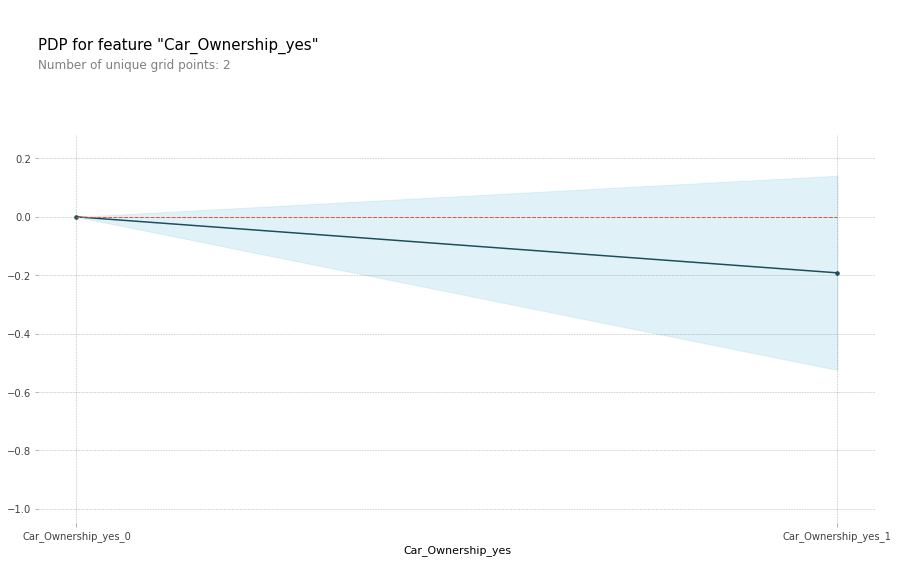

In [75]:
feature = sorted(p_i, key=lambda x: x[1], reverse=True)[0][0]
model = pipe_RFC.named_steps['RFclassifier']

pdp_isolated = get_pdp_isolated(X_val, model, feature)
pdp_plot(pdp_isolated, feature_name=feature)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe1502d4fd0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe1502d4110>})

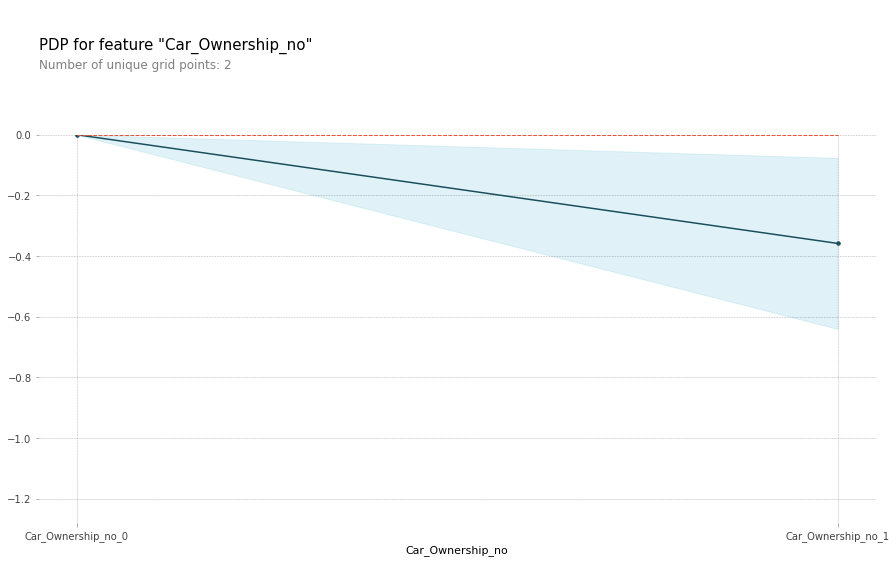

In [76]:
feature = sorted(p_i, key=lambda x: x[1], reverse=True)[1][0]

pdp_isolated = get_pdp_isolated(X_val, model, feature)
pdp_plot(pdp_isolated, feature_name=feature)

In [77]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

def get_pdp_interaction(dataset, model, features):
    pdp_interaction = pdp_interact(
        model = model,
        dataset = dataset,
        model_features = dataset.columns,
        features = features
    ) 

    return pdp_interaction

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe150169890>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe150213410>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


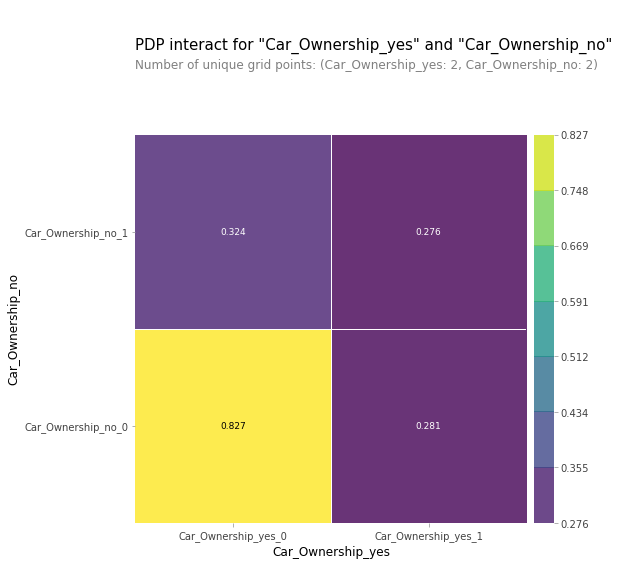

In [78]:
features = list(map(lambda x: x[0], sorted(p_i, key=lambda x: x[1], reverse=True)))[:2]
pdp_interaction = get_pdp_interaction(X_val, model, features)
pdp_interact_plot(pdp_interaction, feature_names=features, plot_type='grid')